# Accuracy Metrics

Goal here is to develop three different accuracy metrics for the EEG online decoder. The three accuracy metrics are described as follows:

**1. Fraction of time target is acquired:** The decoder will move in the direction of the on screen targets. Eventually the decoer will saturate and be at the same location as the on-screen target. This method will compute accuracy as the fraction of time the decoders position is equal to the target position (divided by the fraction of time the decoder is not at the center of the screen). The decoder is assumed to be inactive when it is at the center of the screen so these timesteps are omitted from the accuracy calculations

**2. Fraction of time decoder is in the correct direction:** This computes the fraction of timesteps the decoder is closest to the correct target.

**3. Fraction of time decoder has the correct velocity:** This computes the velocity of the decoder at every timestep. The fraction of these timesteps where the velocity is in the direction of the correct target (relative to all active timesteps) is then reported as accuracy.

In [3]:
# imports

import sys
# setting path
sys.path.append('/home/brandon/eeg/Offline_EEGNet')


import numpy as np
import matplotlib.pyplot as plt
import preprocessing as pre
from preprocessing import load_data, parse_labels, partition_data, augment_data
from train import train
from torch.utils.data import TensorDataset, DataLoader
import torch
import pdb
from EEGNet import EEGNet
import argparse
import tqdm
from collections import defaultdict
import data.data_util as util

## Load in data to debug the three accuracy metrics

In [5]:
# load in the data
data_file_name = "BM_4_movement_w_feedback_000"
fpath = "/home/brandon/eeg/bci_raspy/data/" + data_file_name
eeg_data = util.load_data(fpath + "/eeg.bin")
task_data = util.load_data(fpath + "/task.bin")

In [ ]:
eeg_data.keys()

In [ ]:
task_data.keys()

In [ ]:
plt.figure()
plt.plot(task_data["decoded_pos"][:,0])   # (t_steps, 2)  each t_step contains (x, y) coordinate of decoder
plt.plot(task_data["state_task"])
plt.legend(["decoder x-position", "state task"])
task_data["decoded_pos"]

In [6]:
# partition the data into trials
# extract trial start times
new_state_bool = np.zeros(task_data['state_task'].size, dtype='bool')
new_state_bool[1:] = (task_data['state_task'][1:] != task_data['state_task'][:-1])
new_state_inds = np.nonzero(new_state_bool)[0]
trial_labels = task_data['state_task'][new_state_inds]
trial_start_times = task_data['time_ns'][new_state_inds] 
eeg_timing = eeg_data['time_ns']




eeg_trials = defaultdict(lambda: [])  
# partition trials
for trial_ix in range(len(trial_labels)-1):
    if int(trial_labels[trial_ix]) == 4:  # skip rest trials
        continue 

    # extract eeg_data indices were trial started and ended
    trial_start_ix = np.where(task_data["time_ns"] > trial_start_times[trial_ix])[0][0] + 50 # omit first second of data
    trial_end_ix = np.where(task_data["time_ns"] < trial_start_times[trial_ix+1])[0][-1]
    
    # get the decoder position
    eeg_trials[trial_labels[trial_ix]].append(task_data["decoded_pos"][trial_start_ix:trial_end_ix])

    # append data from 64 electrodes
    #eeg_trials.append(eeg_data['databuffer'][trial_start_ix:trial_end_ix, :64])
    #min_trial_len = np.minimum(eeg_trials[-1].shape[0], min_trial_len).astype(int)
    #eeg_trial_labels.append(class_names[trial_labels[trial_ix]])

### eeg_trials
This is a dictionary where the keys are the trial labels (0 for left, 1 for right). The dictionary contains a list of all trials with the corresponding label (with the first second omitted). The trial is formatted as (t_steps, 2) where at each t_step the x,y-coordinate of the deocder is stored.

In [ ]:
new_state_inds

Text(0.5, 1.0, 'X-position of Decoder During right trial')

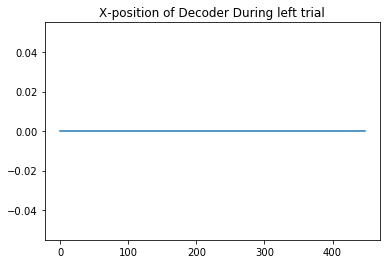

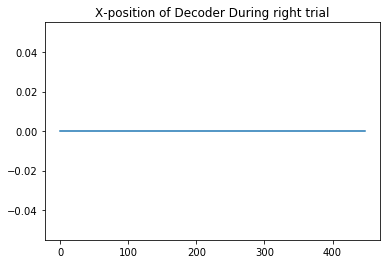

In [7]:
sample_trial_ix = 6  # random trial to visualize

plt.figure()
plt.plot(eeg_trials[0][sample_trial_ix][:,0])
plt.title("X-position of Decoder During left trial")

plt.figure()
plt.plot(eeg_trials[1][sample_trial_ix][:,0])
plt.title("X-position of Decoder During right trial")

In [ ]:
tmp = np.clip(eeg_trials[0], -30, 30)
tmp == [3, 3]

In [8]:
targets = np.unique(task_data["state_task"]) 
targets = list(filter(lambda x: x != 4, targets))  # remove resting state
n_targets = len(targets)
print("number of targets:", n_targets)
print("targets:", targets)

number of targets: 4
targets: [0, 1, 2, 3]


## correct if target was reached otherwise take endpoint as decision

In [9]:
def count_correct_trials(decoder_positions, target, method="near"):
    '''
    returns the number of total and correct trials
    
    decoder_positions is a numpy array with shape 
    (n_trials, t_steps, 2) that contians the x and 
    y positions predicted by the decoder for each 
    timestep of each trial. decoder_positions must 
    only contain trials of the same type (e.g. left 
    reach trials). 
    
    The common label/target for these trials is given 
    by target position. 
    
    method can be "near" or "hit". If "near" a trial that hits 
    the correct target or ends near the correct target will 
    be considered correct. If "hit" only trials that actually 
    hit the correct target are considered correct.
    
    NOTE: this is only implemented for a one dimensional 
    decoder using the x-position
    
    '''
    n_trials = decoder_positions.shape[0]
    t_steps = decoder_positions.shape[1]
    n_correct = 0 
    
    target = target[0]  # only consider one dimensional task
    
    # loop over trials
    for trial_ix in range(n_trials):
        # loop over timesteps in current trial
        n_correct += is_trial_correct(decoder_positions[trial_ix], target, method=method)
    # end loop over trials
    return n_correct, n_trials

def is_trial_correct(decoder_positions, target, method="near"):
    t_steps = decoder_positions.shape[0]
    # loop over timesteps
    for t_step in range(t_steps):
        # the target was hit
        if decoder_positions[t_step, 0] == target:
            #print("target was acquired")
            return True
        # the wrong target was hit
        if decoder_positions[t_step, 0] == -target:
            #print("wrong target was acquired")
            return False    # don't consider future timesteps in this trial
    # end loop over timesteps
    # the target was never hit
    # take the final position as the decision
    if np.sign(decoder_positions[t_step, 0]) == np.sign(target) and method=="near":
        # decoder position was closest to (had the same sign) as the
        # correct target position
        #print("trial ended with decoder near target")
        return True   # count this is a correct trial
    return False  # target wasn't hit

In [ ]:
decoder_pos[0].shape

In [ ]:
decoder_thresh = 75  # value at which decoder reaches target

# maps target to decoder position
target2pos = {
    0 : [-decoder_thresh, 0],  # left
    1 : [decoder_thresh, 0],   # right
    2 : [0, -decoder_thresh],  # down
    3 : [0, decoder_thresh]    # up
}

# stores the total number of trials for each target type
n_trials = defaultdict(lambda: -1)
# stores the number of correct trials for each target type
n_correct = defaultdict(lambda: -1)

# holds thresholded the decoder position
decoder_pos = defaultdict(lambda: 0)

# compute per-class accuracy
verbose = True  # prints intermediate values
decoder_acc = defaultdict(lambda: 0)
for target in targets:
    decoder_pos[target] = np.clip(eeg_trials[target], -decoder_thresh, decoder_thresh)
    n_correct[target], n_trials[target] = count_correct_trials(decoder_pos[target], target2pos[target], method="hit")
    #correct_steps = decoder_pos[target] == target2pos[target]
    #correct_steps = np.sum(correct_steps, axis=-1)
    #correct_steps = np.where(correct_steps==2)[0].shape[0]
    #assert False
    
    
    #correct_steps = decoder_pos == target2pos[target]
    #correct_steps = np.sum(correct_steps, axis=-1)
    #correct_steps = np.where(correct_steps==2)[0].shape[0]
    
    #n_trials = decoder_pos[target].shape[0] 
    #n_tsteps_per_trial = decoder_pos[target].shape[1]
    #n_active_steps[target] = n_trials * n_tsteps_per_trial
    
    acc = n_correct[target]*100./n_trials[target]
    decoder_acc[target] = np.maximum(0., acc)  # negative accuracy indicates unknown class
    if verbose:
        print("\nTarget:", target)
        print("total number of steps during this target:", n_trials[target])
        print("number of correct steps:")
        print("accuracy(%):", acc )
    
# decoder_acc[target_ix] = accuracy_of_decoder_for_that_target

In [ ]:
# compute combined decoder accuracy
numerator = 0
denominator = 1e-12
for target in targets:
    numerator += n_correct[target]
    denominator += n_trials[target]
print("combined accuracy:", 100.*numerator/denominator, "%")

## Metric #2: Decoder in Correct Direction


In [ ]:
# maps target to decoder position
target2pos = {
    0 : [-decoder_thresh, 0],  # left
    1 : [decoder_thresh, 0],   # right
    2 : [0, -decoder_thresh],  # down
    3 : [0, decoder_thresh]    # up
}

# stores total number of decoded steps during each target
n_active_steps = defaultdict(lambda: -1)
correct_steps = defaultdict(lambda: 0)
# threshold the decoder


# compute per-class accuracy
decoder_pos = defaultdict(lambda: 0)
verbose = True  # prints intermediate values
decoder_acc = defaultdict(lambda: 0)
for target in targets:
    decoder_pos[target] = np.sign(eeg_trials[target])
    correct_steps[target] = decoder_pos[target] == np.sign(target2pos[target])  # signs are the same when it is closest
    correct_steps[target] = np.sum(correct_steps[target], axis=-1)
    correct_steps[target] = np.where(correct_steps[target]==2)[0].shape[0]
    
    # total number of decoded steps
    n_trials = decoder_pos[target].shape[0] 
    n_tsteps_per_trial = decoder_pos[target].shape[1]
    n_active_steps[target] = n_trials * n_tsteps_per_trial
    
    acc = correct_steps[target]*100./n_active_steps[target]
    decoder_acc[target] = np.maximum(0., acc)  # negative accuracy indicates unknown class
    if verbose:
        print("\nTarget:", target)
        print("total number of steps during this target:", n_active_steps[target])
        print("number of correct steps:", correct_steps)
        print("accuracy(%):", acc )
    
# decoder_acc[target_ix] = accuracy_of_decoder_for_that_target

# compute combined decoder accuracy
numerator = 0
denominator = 1e-12
for target in targets:
    numerator += correct_steps[target]
    denominator += n_active_steps[target]
print("combined accuracy:", 100.*numerator/denominator, "%")

## Metric #3: Decoder has Correct Velocity

In [ ]:
# maps target to decoder position
target2pos = {
    0 : [-decoder_thresh, 0],  # left
    1 : [decoder_thresh, 0],   # right
    2 : [0, -decoder_thresh],  # down
    3 : [0, decoder_thresh]    # up
}

# stores total number of decoded steps during each target
n_active_steps = defaultdict(lambda: -1)

# threshold the decoder


# compute per-class accuracy
decoder_pos = defaultdict(lambda: 0)
verbose = True  # prints intermediate values
decoder_acc = defaultdict(lambda: 0)
for target in targets:
    decoder_pos[target] = np.diff(eeg_trials[target], axis=-2) # take difference along the time axisy
    decoder_pos[target] = np.sign(decoder_pos[target])   # signed velocity
    correct_steps = decoder_pos[target] == np.sign(target2pos[target])  # signs are the same when moving towards target
    correct_steps = np.sum(correct_steps, axis=-1)
    correct_steps = np.where(correct_steps==2)[0].shape[0]
    
    # total number of decoded steps
    n_trials = decoder_pos[target].shape[0] 
    n_tsteps_per_trial = decoder_pos[target].shape[1]
    n_active_steps[target] = n_trials * n_tsteps_per_trial
    
    acc = correct_steps*100./n_active_steps[target]
    decoder_acc[target] = np.maximum(0., acc)  # negative accuracy indicates unknown class
    if verbose:
        print("\nTarget:", target)
        print("total number of steps during this target:", n_active_steps[target])
        print("number of correct steps:", correct_steps)
        print("accuracy(%):", acc )
    
# decoder_acc[target_ix] = accuracy_of_decoder_for_that_target

In [ ]:
np.sign(0) == np.sign(1)

In [ ]:
n_tsteps_per_trial

In [ ]:
np.array(eeg_trials[target]).shape

# Accuracy Metrics for 2D Decoding 

In [7]:
# load in the data
data_file_name = "jn1_replay_updates"
fpath = "C:/Users/DNNeu/KaoLab/EEG_Decoding/Offline_EEG_Decoding/data/" + data_file_name
eeg_data = util.load_data(fpath + "/eeg.bin")
task_data = util.load_data(fpath + "/task.bin")

In [8]:
# partition the data into trials
# extract trial start times
new_state_bool = np.zeros(task_data['state_task'].size, dtype='bool')
new_state_bool[1:] = (task_data['state_task'][1:] != task_data['state_task'][:-1])
new_state_inds = np.nonzero(new_state_bool)[0]
trial_labels = task_data['state_task'][new_state_inds]
trial_start_times = task_data['time_ns'][new_state_inds] 
eeg_timing = eeg_data['time_ns']




eeg_trials = defaultdict(lambda: [])  
# partition trials
for trial_ix in range(len(trial_labels)-1):
    if int(trial_labels[trial_ix]) == 4:  # skip rest trials
        continue 

    # extract eeg_data indices were trial started and ended
    trial_start_ix = np.where(task_data["time_ns"] > trial_start_times[trial_ix])[0][0] + 50 # omit first second of data
    trial_end_ix = np.where(task_data["time_ns"] < trial_start_times[trial_ix+1])[0][-1]
    
    # get the decoder position
    eeg_trials[trial_labels[trial_ix]].append(task_data["decoded_pos"][trial_start_ix:trial_end_ix])

    # append data from 64 electrodes
    #eeg_trials.append(eeg_data['databuffer'][trial_start_ix:trial_end_ix, :64])
    #min_trial_len = np.minimum(eeg_trials[-1].shape[0], min_trial_len).astype(int)
    #eeg_trial_labels.append(class_names[trial_labels[trial_ix]])

In [9]:
targets = np.unique(task_data["state_task"]) 
targets = list(filter(lambda x: x != 4, targets))  # remove resting state
n_targets = len(targets)
print("number of targets:", n_targets)
print("targets:", targets)

number of targets: 2
targets: [0, 1]


## Compute Weak Accuracy Metric for 2D Decoding

The accuracy is computed for the 2D decoding task (left/right/up/down). A trial is considered accurate as long as the decoded cursor position ends on the correct half of the screen. 

In [10]:
# maps target label to decoder 2D (x,y) position
target2pos = {
    0 : [-1, 0],  # left
    1 : [1, 0],   # right
    2 : [0, -1],  # down
    3 : [0, 1]    # up
}

# maps each target to a list of bools indicating if that trial is correct
correct_trials = defaultdict(lambda: 0)  
n_trials = defaultdict(lambda: 0)  # number of trials for each condition

# list of decoder positions at the end of all trials
# e.g. final_decoder_pos[0] is a list of (x,y)-coordinates 
# of the final decoder position at the end of each trial 
# associated with left (target=0) reaches
final_decoder_pos = defaultdict(lambda: 0)
decoder_acc = defaultdict(lambda: 0)
for target in targets:
    # eeg_trials[target] is a list with length equal to the number of target trials.
    # Each array is a timeseries of 2D position of the decoder for that trial
    final_decoder_pos[target] = np.array(np.sign(eeg_trials[target]))[:,-1,:]  # final x,y-position of decoder on each trial (n_trials, 2) 
    if target < 2: # L/R
        correct_trials[target] = final_decoder_pos[target][:,0] == target2pos[target][0]  # signs are the same when it is closest
    else: # U/D
        correct_trials[target] = final_decoder_pos[target][:,1] == target2pos[target][1]  # signs are the same when it is closest
    correct_trials[target] = np.sum(correct_trials[target])
    #correct_steps = np.where(correct_steps==2)[0].shape[0]
    
    # total number of this type of trial
    n_trials[target] = final_decoder_pos[target].shape[0] 
    
    # accuracy on this trial type
    acc = correct_trials[target]*100./n_trials[target]
    decoder_acc[target] = np.maximum(0., acc)  # negative accuracy indicates unknown class
    if True:
        print("\nTarget:", target)
        print("correct trials:", correct_trials[target])
        print("trials of this type:", n_trials[target])
        print("accuracy(%):", acc )

total_correct_trials = 0
total_trials = 0
for target in targets:
    total_correct_trials += correct_trials[target]
    total_trials += n_trials[target]
acc = total_correct_trials * 100. / total_trials
print("\n\nAverage accuracy across all trials(%):", acc)
    
# decoder_acc[target_ix] = accuracy_of_decoder_for_that_target


Target: 0
correct trials: 15
trials of this type: 76
accuracy(%): 19.736842105263158

Target: 1
correct trials: 59
trials of this type: 78
accuracy(%): 75.64102564102564


Average accuracy across all trials(%): 48.05194805194805
